In [ ]:
%%capture
!pip install tensorly
!pip install sparse

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import math
import sparse
from tensorly.contrib.sparse.decomposition import non_negative_parafac,parafac
from tensorly.contrib.sparse.cp_tensor import cp_to_tensor
from tensorly.contrib.sparse import tensor
import tensorly.contrib.sparse as stl
from datetime import datetime as dt
from datetime import timedelta as td

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/Knowledge Graphs 2022/'
%cd $FOLDER_PATH

/content/drive/.shortcut-targets-by-id/18wZgIc4f2VuuQ34uv_vRrBAOHvMWSEaq/Knowledge Graphs 2022


# Data Import

In [ ]:
all_tweets_df = pd.read_csv("data/tweets_cleaned_text.csv")
all_tweets_df

,id,text,time,cleaned_text
0,1420959115879145474,https://t.co/3bM9PoSxS6 #acoustic #orchestra #...,Fri Jul 30 04:07:08 +0000 2021,[]
1,1420589578541428739,@DekeSlade Hey Rj! A link to my youtube chann...,Thu Jul 29 03:38:43 +0000 2021,"['youtube', 'channel', 'video', 'music', 'feat..."
2,1420533067400105985,@kraftoki @MinxMore How do you know?,Wed Jul 28 23:54:10 +0000 2021,['know']
3,1420373718828679174,"@MinxMore Also, consider that ""immune for only...",Wed Jul 28 13:20:58 +0000 2021,"['consider', 'immune', 'month', 'come', 'journ..."
4,1420373378653773829,@MinxMore It's like chicken pox....,Wed Jul 28 13:19:37 +0000 2021,['chicken']
...,...,...,...,...
923380,1397974274367963136,@Baklava_in_CA @jordanbpeterson I got my pound.,Thu May 27 17:53:34 +0000 2021,['pound']
923381,1397972983067693064,@nypost He tries to turn his hotel rooms into ...,Thu May 27 17:48:26 +0000 2021,"['turn', 'hotel', 'room', 'vermont']"
923382,1397972391708475392,@Baklava_in_CA @jordanbpeterson I've realized ...,Thu May 27 17:46:05 +0000 2021,"['realize', 'never', 'debt', 'alone', 'interes..."
923383,1397813255523995648,"So, what do you think the long term side effec...",Thu May 27 07:13:44 +0000 2021,"['think', 'long', 'term', 'side', 'effect']"


In [ ]:
pre_kg_completion_flag = True
if pre_kg_completion_flag:
  tweets_w_topic_df = pd.read_csv("data/all_tweets_50_topics.csv")
else:
  tweets_w_topic_df = pd.read_csv("data/tweets_w_recovered_50_topics.csv")

topic_0_df = tweets_w_topic_df[tweets_w_topic_df['topic'] == 0]
topic_0_df = topic_0_df[['id', 'text', 'time', 'user_id', 'user_screen_name']].merge(all_tweets_df[['id', 'cleaned_text']], on='id')
topic_0_df.rename(columns = {"time":"timestamp"}, inplace = True)
topic_0_df['time'] = pd.to_datetime(topic_0_df['timestamp'], infer_datetime_format=True).apply(lambda x: x.date())
end_time = sorted(topic_0_df['time'])[-1]
start_time = end_time - td(days=365)
topic_0_df = topic_0_df[(topic_0_df['time'] >= start_time) & (topic_0_df['time'] <= end_time)]
topic_0_df.sort_values(by='time', inplace=True)
topic_0_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,id,text,timestamp,user_id,user_screen_name,cleaned_text,time
10143,1290058264911081472,@JoeBiden Then make sure you vote for @POTUS,Sun Aug 02 22:53:53 +0000 2020,756339957069996032,Reponite,"['make', 'sure', 'vote']",2020-08-02
2989,1290137241671446528,@JudgeJeaninefan PA,Mon Aug 03 04:07:42 +0000 2020,2886893817,cshalluck,[],2020-08-03
6255,1290631229910536195,From the Rockefeller Foundation's 2010 Annual ...,Tue Aug 04 12:50:38 +0000 2020,1488430634,captainglom,"['rockefeller', 'foundation', 'annual', 'report']",2020-08-04
2500,1290504503360229377,@kayleighmcenany @realDonaldTrump But the Left...,Tue Aug 04 04:27:04 +0000 2020,806915357805903872,mgr842day,"['left', 'massive', 'cheating', 'plan', 'pract...",2020-08-04
10142,1290778084518629376,@mmpadellan @IanSeign All dead and illegal vot...,Tue Aug 04 22:34:11 +0000 2020,756339957069996032,Reponite,"['dead', 'illegal', 'voter', 'removedpurged', ...",2020-08-04
...,...,...,...,...,...,...,...
759,1421995813732036611,@miles_commodore Mental laziness.,Mon Aug 02 00:46:36 +0000 2021,87209404,garbo1014,"['mental', 'laziness']",2021-08-02
767,1421995991612362756,@ErieNotEerie vote manipulation.,Mon Aug 02 00:47:18 +0000 2021,20931953,maison21,"['vote', 'manipulation']",2021-08-02
772,1422003687271055362,Flashback: On Election Night Chris Wallace Sai...,Mon Aug 02 01:17:53 +0000 2021,15100622,MR_PUNJABI,"['flashback', 'election', 'night', 'chris', 'w...",2021-08-02
617,1422302991168704513,Americas Audit Update: HUGE Week Expected In 3...,Mon Aug 02 21:07:12 +0000 2021,4427177261,cynkading,"['america', 'audit', 'update', 'huge', 'week',...",2021-08-02


## Data Preprocessing

In [ ]:
# The legacy code works with json/dictionaries, whereas we work with pandas dataframes
# this function converts a pandas dataframe into a list of json dictionaries

def pd_to_js(df):
  # given a pandas dataframe, this produces a python list, with one entry
  # for each row in the pd dataframe, and each entry of the list is a dictionary
  # which encodes the information in the dataframe
  
  # produce an in-order array of keys
  keys = []
  for key in df:
    keys += [key]

  # assemble a list of data things
  outList = []
  for index, row in df.iterrows():
    outList += [row_to_dict(row, keys)]
  return outList

# helper function for pd_to_js
def row_to_dict(df_row, keys):
  # recieves a dataframe row, and produces a dictionary encoding the information
  # in that row
  outDict = {}
  for index, value in enumerate(df_row):
    outDict[keys[index]] = value
  return outDict

In [ ]:
topic_0_list = pd_to_js(topic_0_df)

# turns the cleaned_text category into a list, not a string
for tweet in topic_0_list:
  tweet['cleaned_text'] = tweet['cleaned_text'][2:-2].split(r"', '")

In [ ]:
# this parameter is used in filenames
# be VERY careful to run this cell correctly
min_freq = 25
n_topics = 5
filtered = True
voc_name = f'pre_completion_topic_0_voc_min_freq: {min_freq}'
task_name = f'pre_completion_topic_0_min_freq: {min_freq}, topics: {n_topics}'
if filtered:
  voc_name += " filtered"
  task_name += "filtered "
data = topic_0_list

## DateTime

In [ ]:
# assembles a list of dates contained in the tweet data
times = []
for  tweet in data:
  t = tweet['time']
  if not (t in times):
    times.append(t)
print(len(times))
print(times) # should be sorted already

362
[datetime.date(2020, 8, 2), datetime.date(2020, 8, 3), datetime.date(2020, 8, 4), datetime.date(2020, 8, 5), datetime.date(2020, 8, 6), datetime.date(2020, 8, 7), datetime.date(2020, 8, 9), datetime.date(2020, 8, 10), datetime.date(2020, 8, 11), datetime.date(2020, 8, 12), datetime.date(2020, 8, 13), datetime.date(2020, 8, 14), datetime.date(2020, 8, 15), datetime.date(2020, 8, 16), datetime.date(2020, 8, 17), datetime.date(2020, 8, 18), datetime.date(2020, 8, 20), datetime.date(2020, 8, 21), datetime.date(2020, 8, 23), datetime.date(2020, 8, 24), datetime.date(2020, 8, 25), datetime.date(2020, 8, 26), datetime.date(2020, 8, 27), datetime.date(2020, 8, 28), datetime.date(2020, 8, 29), datetime.date(2020, 8, 30), datetime.date(2020, 8, 31), datetime.date(2020, 9, 1), datetime.date(2020, 9, 2), datetime.date(2020, 9, 3), datetime.date(2020, 9, 4), datetime.date(2020, 9, 5), datetime.date(2020, 9, 6), datetime.date(2020, 9, 7), datetime.date(2020, 9, 8), datetime.date(2020, 9, 9), dat

# Data slice

## Slice by tweets

In [ ]:
slice_size = 2000
tweet_slices = [data[i:i+slice_size] for i in range(0, len(data), slice_size)][:-1]
print(len(tweet_slices))

4


# TFIDF

In [ ]:
n_components = n_topics
n_top_words = 20

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df:list,vocab=None):
  # This function turns the data that we have into a term/frequency matrix
  # using sklearn TfIdf tools.
  docs = [tweet['cleaned_text'] for tweet in df]
  texts = docs
  vectorizer = TfidfVectorizer(vocabulary=vocab)
  # the vocab parametery determines the counts that vectorizer produces.
  # for each word in vocab, we get a row in the resulting term-freq matrix

  for i in range(len(texts)):
    # turns texts[i] from a list of words to a string contianing all words
    # separated by spaces
    texts[i] = ' '.join(texts[i])

  return vectorizer.fit_transform(texts)
  # [vectorizer.fit_transform(texts),vectorizer.get_feature_names()]

def vocabFromTweets(df:list,max_df=1.0, min_df=1, ngram_range=(1, 1)):
  docs = [tweet['cleaned_text'] for tweet in df]
  texts = docs
  vectorizer = TfidfVectorizer(min_df=min_df,max_df=max_df,ngram_range=ngram_range)
  # min_df: ignore all words that occur in fewer than min_df documents
  # max_df: ignore all words that occur in more than the proportion max_df of all documents
    #setting both to one means we basically ignore both
  # ngram_range = (1,1) means we'll only be considering one-word terms

  for i in range(len(texts)):
    texts[i] = ' '.join(texts[i])

  vectorizer.fit_transform(texts)
  # vocabulary_dict:
  #   A mapping of terms to feature indices.
  return vectorizer.vocabulary_

def formatTopic(event:list,fnames:list,nTopTags:int=n_top_words):
  hashtags = [[fnames[i],np.abs(event[i])] for i in range(len(event)) if event[i]!=0]
  hashtags.sort(key=lambda x:x[1],reverse=True)
  hashtags = hashtags[:nTopTags] if nTopTags else hashtags
  return {x[0]:x[1] for x in hashtags}

def outfilename(fname:str):
  return f'NCPD/NCPD for topic election/{fname}'

def outfile(fname:str):
  return open(f'NCPD/NCPD for topic election/{fname}','w')

def plot_top_words_dict(topics, title, save=False):
  width = 5
  if n_components < 5:
    width = n_components
  height = math.ceil(n_components / 5)
  fig, axes = plt.subplots(height, width, figsize=(50, int(7.5 * height + 4)), sharex=True) # change num of topics?
  axes = axes.flatten()
  for indx, topic in enumerate(topics):
    keywords = list(topic)
    weights = [topic[word] for word in keywords]

    ax = axes[indx]
    ax.barh(keywords, weights, height=0.7)
    ax.set_title(f'Topic {indx}',
                  fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
  if save:
    plt.savefig(f'NCPD/NCPD for topic election/{task_name}.pdf')



### Vocabulary

In [ ]:
# This is a manually assmembled of meaningless words that were mucking up
# the NCPD results. I'm manually removing them from the vocabulary.
str_to_remove = """[think, dont, know, would, thats, make, need, take, well, back,
                    come, cant, really, want, thing, look, unfollowed, follow, 
                    exactly, away, another, must, youre, give, track, follower, 
                    unfollower, find, unfollowers, gain, lose, follow, please]"""
words_to_remove = str_to_remove[1:-1].replace('\n', '').split(", ")
words_to_remove = [word.strip() for word in words_to_remove]


In [ ]:
# Create vocab list from full data
# only including words occuring at least as often than min_freq
voc_freq_dict = {}
for index, row in enumerate(data):
  cleaned_text_list = row['cleaned_text']
  for word in cleaned_text_list:
    word = word.lower()
    if word not in voc_freq_dict.keys():
      voc_freq_dict[word] = 1
    else:
      voc_freq_dict[word] += 1

voc_list = []
for word, freq in voc_freq_dict.items():
  if freq >= min_freq:
    voc_list += [word.lower()]

if filtered:
  voc_list = list(set(voc_list) - set(words_to_remove))

print(f"The vocabulary list has {len(voc_list)} words.")


The vocabulary list has 495 words.


In [ ]:
# save vocabulary list to a pickle
voc_filename = f"NCPD/NCPD for topic election/{voc_name}_voc"
voc_outfile = open(voc_filename, 'wb')
pickle.dump(voc_list, voc_outfile)
voc_outfile.close()

In [ ]:
# Load from file
voc_filename = f"NCPD/NCPD for topic election/{voc_name}_voc"
voc_infile = open(voc_filename,'rb')
voc_list = pickle.load(voc_infile)
voc_infile.close()

print(f"The vocabulary list has {len(voc_list)} words.")

The vocabulary list has 495 words.


# NCPD

In [ ]:
voc = voc_list
tf_results = [tfidf(day,voc) for day in tweet_slices]

In [ ]:
nSlices = len(tf_results)
tf_data= tf_results[:nSlices]

## Sparse operations

In [ ]:
def sparseItr(mats:list): # list of csr matrices
  result = list()
  for i in range(len(mats)):
    m = mats[i]
    nz = m.nonzero()
    row = nz[0]
    col = nz[1]
    for l in range(len(row)):
      j = row[l]
      k = col[l]
      yield ((i,j,k),m[j,k])

In [ ]:
def factorTensor(slices:int=nSlices):
  tf = sparse.COO(coords=sparseItr(tf_results[:slices]),shape=(slices,slice_size,len(voc)))
  return non_negative_parafac(tensor(tf),rank=n_components, init='random')
# 1st line Time for whole dataset (2k slice size, 1.8k keywords): 2min
### 2nd line time: shape=(30, 1835, 1827)->18m2s

import os


def save(factors,slices:int=nSlices): # file name indicates (rank,slices/total slices)
  time_topic = factors[1][0]
  topic_tweet = factors[1][1].transpose()
  topic_kw = factors[1][2].transpose()

  folder = 're('+str(n_components)+','+str(slices)+'-'+str(len(tf_results))+')'
  os.makedirs(outfilename(folder), exist_ok=True)

  with outfile(folder+'/slice_topic.json') as file:
    json.dump(time_topic.todense().tolist(),file)

  with outfile(folder+'/topic_tweet.json') as file:
    json.dump(topic_tweet.todense().tolist(),file)

  with outfile(folder+'/topic_kw.json') as file:
    json.dump(topic_kw.todense().tolist(),file)

  # with outfile('wordlist.json') as file:
  #   json.dump(voclist,file)

  voc.sort()
  topics = [formatTopic(event,voc) for event in topic_kw]
  with outfile(folder+'/topics.json') as file:
    json.dump(topics,file)


In [ ]:
nSlices = len(tf_results)
fctr2 = factorTensor(nSlices)
# Time: ~0.5h/30 slices, 20 topics
# ~2.5h/306,20
# /306,100

In [ ]:
# save fctr2 to a pickle
fctr2_filename = f"NCPD/NCPD for topic election/{task_name}_fctr2"
fctr2_outfile = open(fctr2_filename, 'wb')
pickle.dump(fctr2, fctr2_outfile)
fctr2_outfile.close()

In [ ]:
# load fctr2 from a pickle
fctr2_filename = f"NCPD/NCPD for topic election/{task_name}_fctr2"
fctr2_infile = open(fctr2_filename,'rb')
fctr2 = pickle.load(fctr2_infile)
fctr2_infile.close()

In [ ]:
print(fctr2)
print(task_name)

(weights, factors) : rank-5 CPTensor of shape (4, 2000, 495) 
pre_completion_topic_0_min_freq: 25, topics: 5filtered 


# Save and Interpret Results

In [ ]:
topic_time = fctr2[1][0]
topic_tweet = fctr2[1][1].transpose()
topic_kw = fctr2[1][2].transpose()

In [ ]:
# voc.sort()
topics = [formatTopic(event,voc) for event in topic_kw]

# save topics to a pickle
topics_filename = f"NCPD/NCPD for topic election/{task_name}_topics"
topics_outfile = open(topics_filename, 'wb')
pickle.dump(topics, topics_outfile)
topics_outfile.close()

In [ ]:
# load topics from a pickle
topics_filename = f"NCPD/NCPD for topic election/{task_name}_topics"
topics_infile = open(topics_filename,'rb')
topics = pickle.load(topics_infile)
topics_infile.close()

In [ ]:
topic_kw

Format,coo
Data Type,float64
Shape,"(5, 495)"
nnz,2475
Density,1.0
Read-only,True
Size,58.0K
Storage ratio,3.0


In [ ]:
save(fctr2, 4)

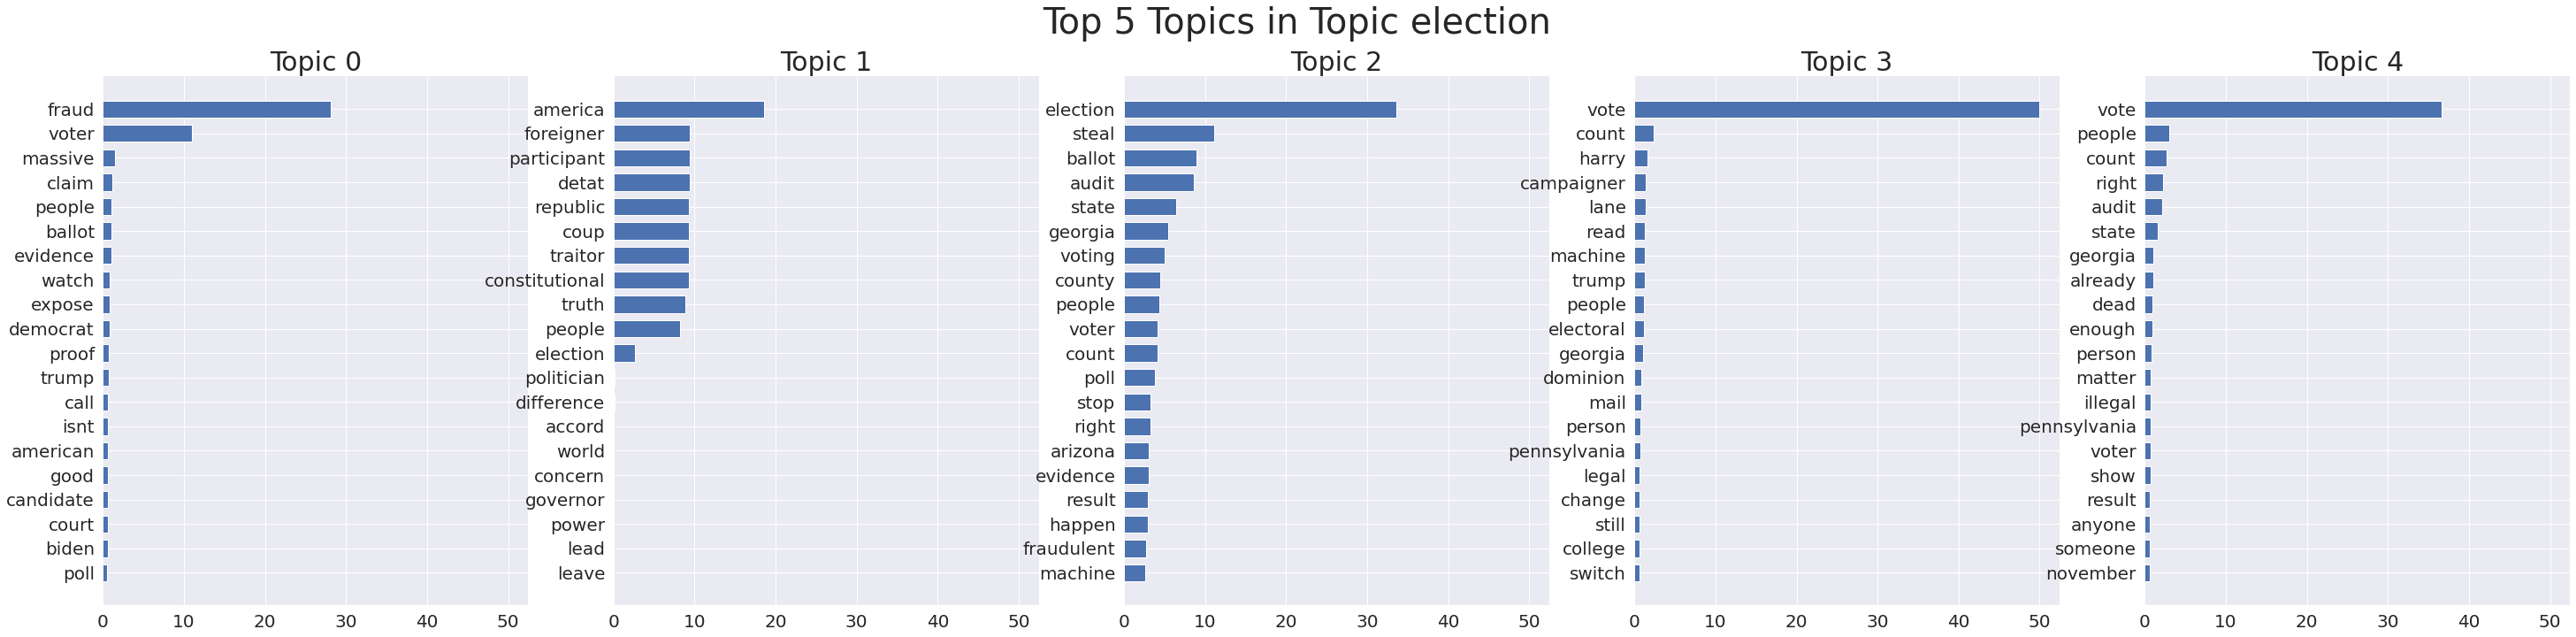

In [ ]:
plot_top_words_dict(topics,'Top 5 Topics in Topic election',True)
# plt.savefig(outfilename('re_NCPD.png'))

# Animation

In [ ]:
print(topic_time.shape)
topic_names = ['Topic '+str(i) for i in range(n_components)]
if len(topic_time) == n_components:
  topic_time = topic_time.transpose()

(22, 5)


NameError: ignored

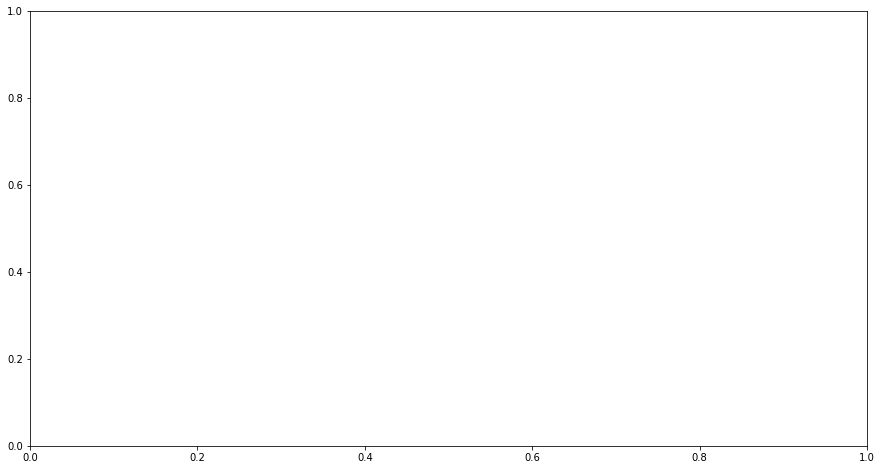

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15, 8))

height = 0.5


def draw_barchart(day:int):
  plt.cla()
  distr = topic_time[day]
  ax.bar(topic_names, distr, animated=True)
  ax.set_ylim([0,height])
  plt.title(str(times[day]))

animator = FuncAnimation(fig, draw_barchart, frames=range(Days))
HTML(animator.to_html5_video())
animator.save(outfilename('NCPD.mp4'))

0.9


NameError: ignored

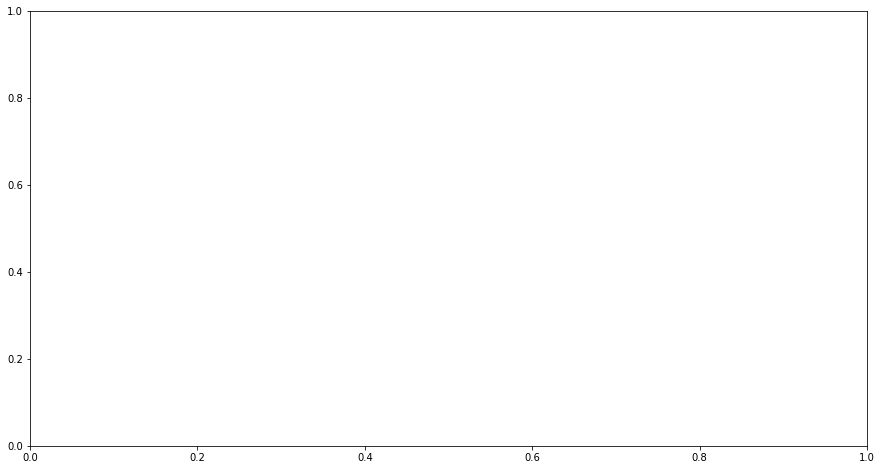

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

def normalize(x:list):
  s = sum(x)
  return [y/s for y in x] if s else x

normalized_distr = [normalize(x) for x in topic_time]

height = np.ceil(10*np.max([np.max(x) for x in normalized_distr]))*0.1+0.1
print(height)

# Interpolate by hour
def interpolate(start:list, end:list, curTime:int, totalTime:int):
  assert len(start)==len(end)
  a = curTime/totalTime
  b = 1-a
  return [b*start[i]+a*end[i] for i in range(len(start))]

interpolated = [interpolate(normalized_distr[i//24],normalized_distr[i//24+1],i%24,24) for i in range(24*(Days-1))]
baseTime = times[0]
titles = [str(baseTime+td(hours=i)) for i in range(len(interpolated))]

def draw_barchart(day:int):
  plt.cla()
  distr = interpolated[day]
  ax.bar(topic_names, distr, animated=True)
  ax.set_ylim([0,height])
  plt.title(titles[day])

animator = FuncAnimation(fig, draw_barchart, frames=range(len(interpolated)))
# HTML(animator.to_html5_video())
animator.save(outfilename('NCPD.mp4'),fps=24)

### Time: 122s

TODO: 
- normalize to tweet volume
- deal with downsampling (random?)
- expand time (timespan; use hour instead of interpolation) 
- [interpolation]

Meeting: 
- Sparse
  - Branching to solve vocab noise
- Slice size
- Heatmap


# Heatmap

In [ ]:
from pandas import DataFrame
import seaborn as sns

In [ ]:
def dtToStr(d:dt):
  return d.strftime('%y %b %d')

def normalize(x:list,max:float=1):
  s = sum(x)
  return [y*max/s for y in x] if s else x

# normalized_distr = [normalize(x,1) for x in time_topic]
with open(outfilename('re(5,22-22)/slice_topic.json')) as file:  
  normalized_distr = [normalize(x,1) for x in json.load(file)]

In [ ]:
Index = ['Topic '+str(i) for i in range(n_components)]
Cols = [dtToStr(t) for t in times]
df = DataFrame(index=Index,columns=Cols,dtype=float,data=0)

In [ ]:
daysToSlices = {col:{} for col in Cols}
# data_df = pd.normalize(data)
# tweet_slices = [data_df[i:i+slice_size] for i in range(0, len(data), slice_size)][:-1]


for i, twt_slc in enumerate(tweet_slices):
  for tweet_num, tweet in enumerate(twt_slc):
#     dct = daysToSlices[dtToStr(tweet['time'])]
# for i in range(len(tweet_slices)):
#   for tweet in tweet_slices[i]:
    dct = daysToSlices[dtToStr(tweet['time'])]
    if i in dct:
      dct[i] += 1
    else:
      dct[i] = 1

In [ ]:
print(type(tweet_slices[0]))

<class 'list'>


In [ ]:
print(daysToSlices)

{'20 Aug 02': {0: 1}, '20 Aug 03': {0: 1}, '20 Aug 04': {0: 3}, '20 Aug 05': {0: 4}, '20 Aug 06': {0: 3}, '20 Aug 07': {0: 1}, '20 Aug 09': {0: 1}, '20 Aug 10': {0: 4}, '20 Aug 11': {0: 5}, '20 Aug 12': {0: 1}, '20 Aug 13': {0: 3}, '20 Aug 14': {0: 3}, '20 Aug 15': {0: 5}, '20 Aug 16': {0: 2}, '20 Aug 17': {0: 3}, '20 Aug 18': {0: 3}, '20 Aug 20': {0: 3}, '20 Aug 21': {0: 5}, '20 Aug 23': {0: 3}, '20 Aug 24': {0: 3}, '20 Aug 25': {0: 1}, '20 Aug 26': {0: 9}, '20 Aug 27': {0: 1}, '20 Aug 28': {0: 3}, '20 Aug 29': {0: 4}, '20 Aug 30': {0: 3}, '20 Aug 31': {0: 7}, '20 Sep 01': {0: 3}, '20 Sep 02': {0: 3}, '20 Sep 03': {0: 4}, '20 Sep 04': {0: 3}, '20 Sep 05': {0: 4}, '20 Sep 06': {0: 2}, '20 Sep 07': {0: 10}, '20 Sep 08': {0: 1}, '20 Sep 09': {0: 3}, '20 Sep 10': {0: 3}, '20 Sep 11': {0: 3}, '20 Sep 12': {0: 3}, '20 Sep 14': {0: 2}, '20 Sep 15': {0: 1}, '20 Sep 16': {0: 3}, '20 Sep 17': {0: 4}, '20 Sep 18': {0: 1}, '20 Sep 19': {0: 11}, '20 Sep 20': {0: 11}, '20 Sep 21': {0: 6}, '20 Sep 2

In [ ]:
print(len(normalized_distr[-1]))

5


In [ ]:
for day in daysToSlices:
  slices = daysToSlices[day]
  for i in slices:
    n = slices[i]
    delta_df = DataFrame(index=Index,columns=[day],dtype=float,
                         data=[x*n for x in normalized_distr[i]])
    df = df.add(delta_df,fill_value=0)

df = df.reindex(Cols, axis=1)
print(df)

            20 Aug 02     20 Aug 03     20 Aug 04     20 Aug 05     20 Aug 06  \
Topic 0  5.804813e-04  5.804813e-04  1.741444e-03  2.321925e-03  1.741444e-03   
Topic 1  1.746672e-01  1.746672e-01  5.240017e-01  6.986690e-01  5.240017e-01   
Topic 2  7.728973e-12  7.728973e-12  2.318692e-11  3.091589e-11  2.318692e-11   
Topic 3  8.138591e-05  8.138591e-05  2.441577e-04  3.255436e-04  2.441577e-04   
Topic 4  8.246709e-01  8.246709e-01  2.474013e+00  3.298684e+00  2.474013e+00   

            20 Aug 07     20 Aug 09     20 Aug 10     20 Aug 11     20 Aug 12  \
Topic 0  5.804813e-04  5.804813e-04  2.321925e-03  2.902407e-03  5.804813e-04   
Topic 1  1.746672e-01  1.746672e-01  6.986690e-01  8.733362e-01  1.746672e-01   
Topic 2  7.728973e-12  7.728973e-12  3.091589e-11  3.864487e-11  7.728973e-12   
Topic 3  8.138591e-05  8.138591e-05  3.255436e-04  4.069295e-04  8.138591e-05   
Topic 4  8.246709e-01  8.246709e-01  3.298684e+00  4.123354e+00  8.246709e-01   

         ...  21 Jul 24  2

In [ ]:
df.to_json(outfile('hm_data.json'))

# Heatmap

In [ ]:
!pip install seaborn
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sns.set(font_scale=1.8) 

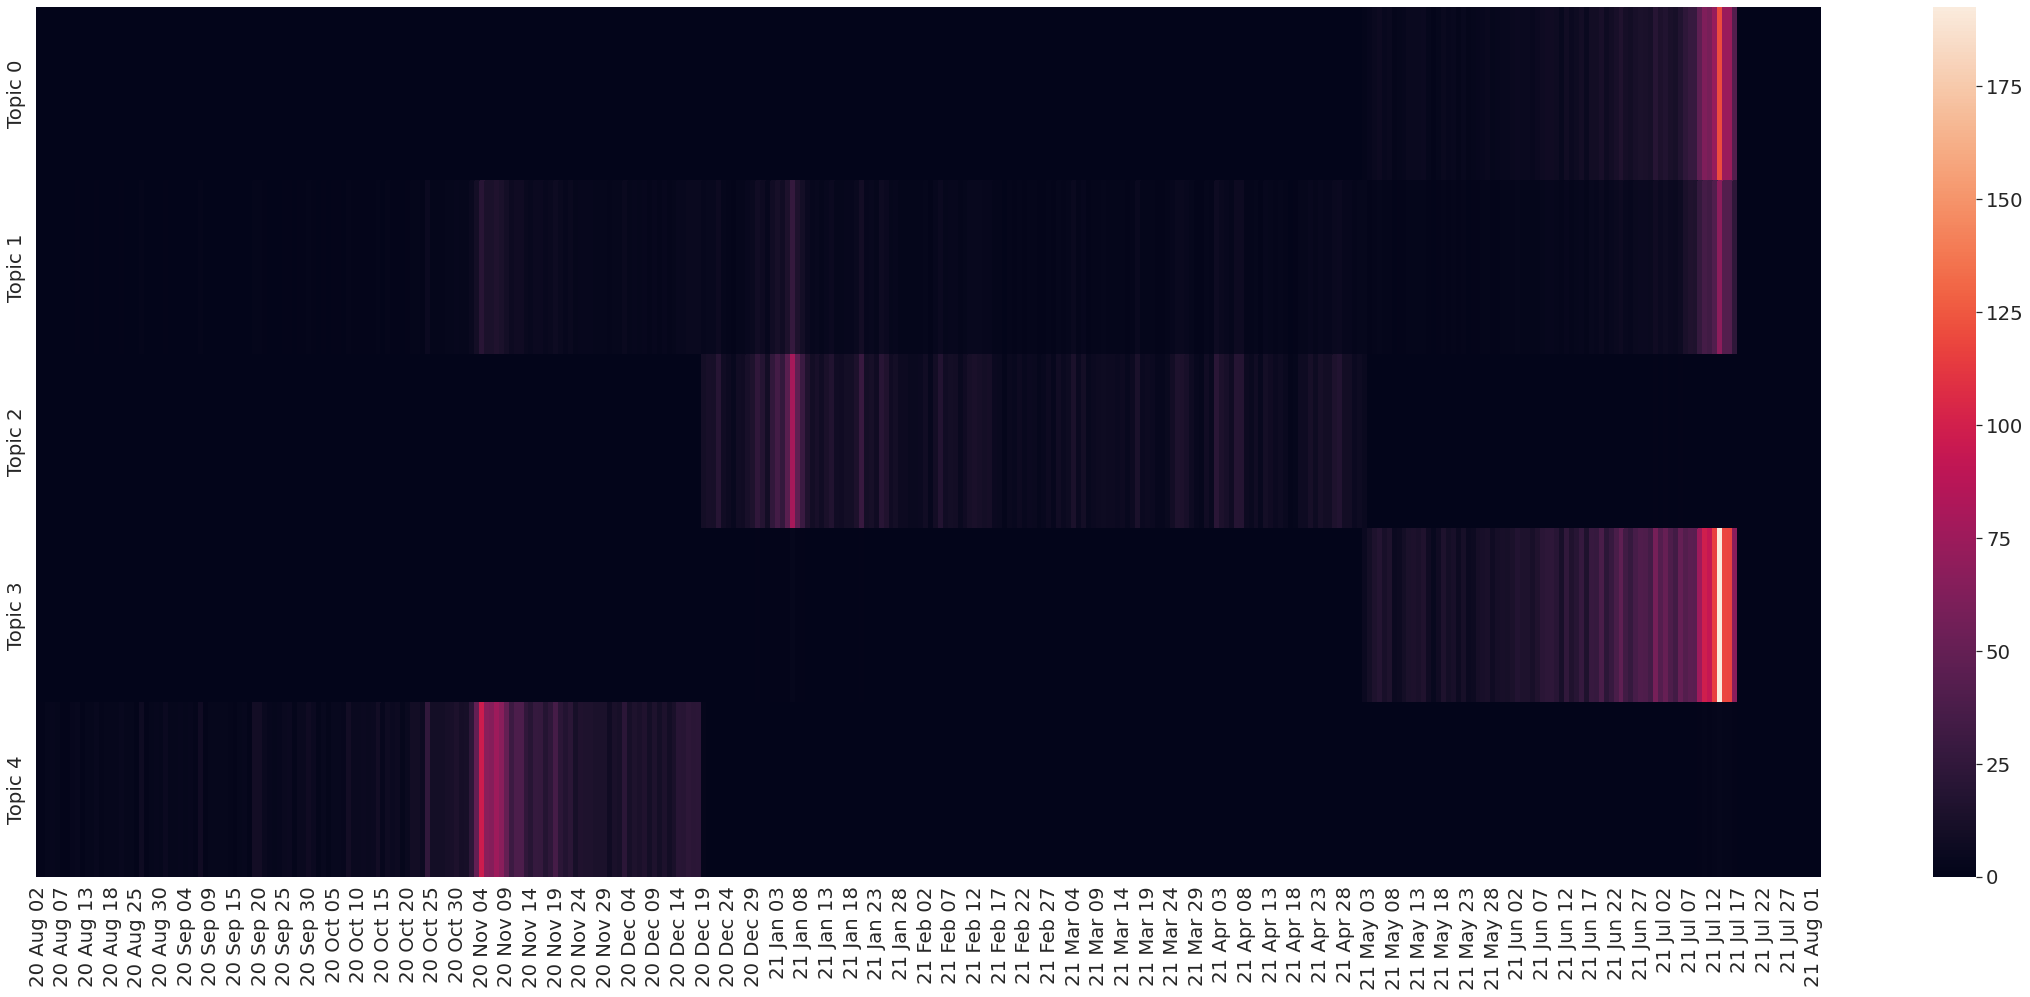

In [ ]:
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df,cmap='rocket') # viridis, inferno, plasma
plt.savefig(f'NCPD/NCPD for topic election/heatmap_{task_name}.pdf')

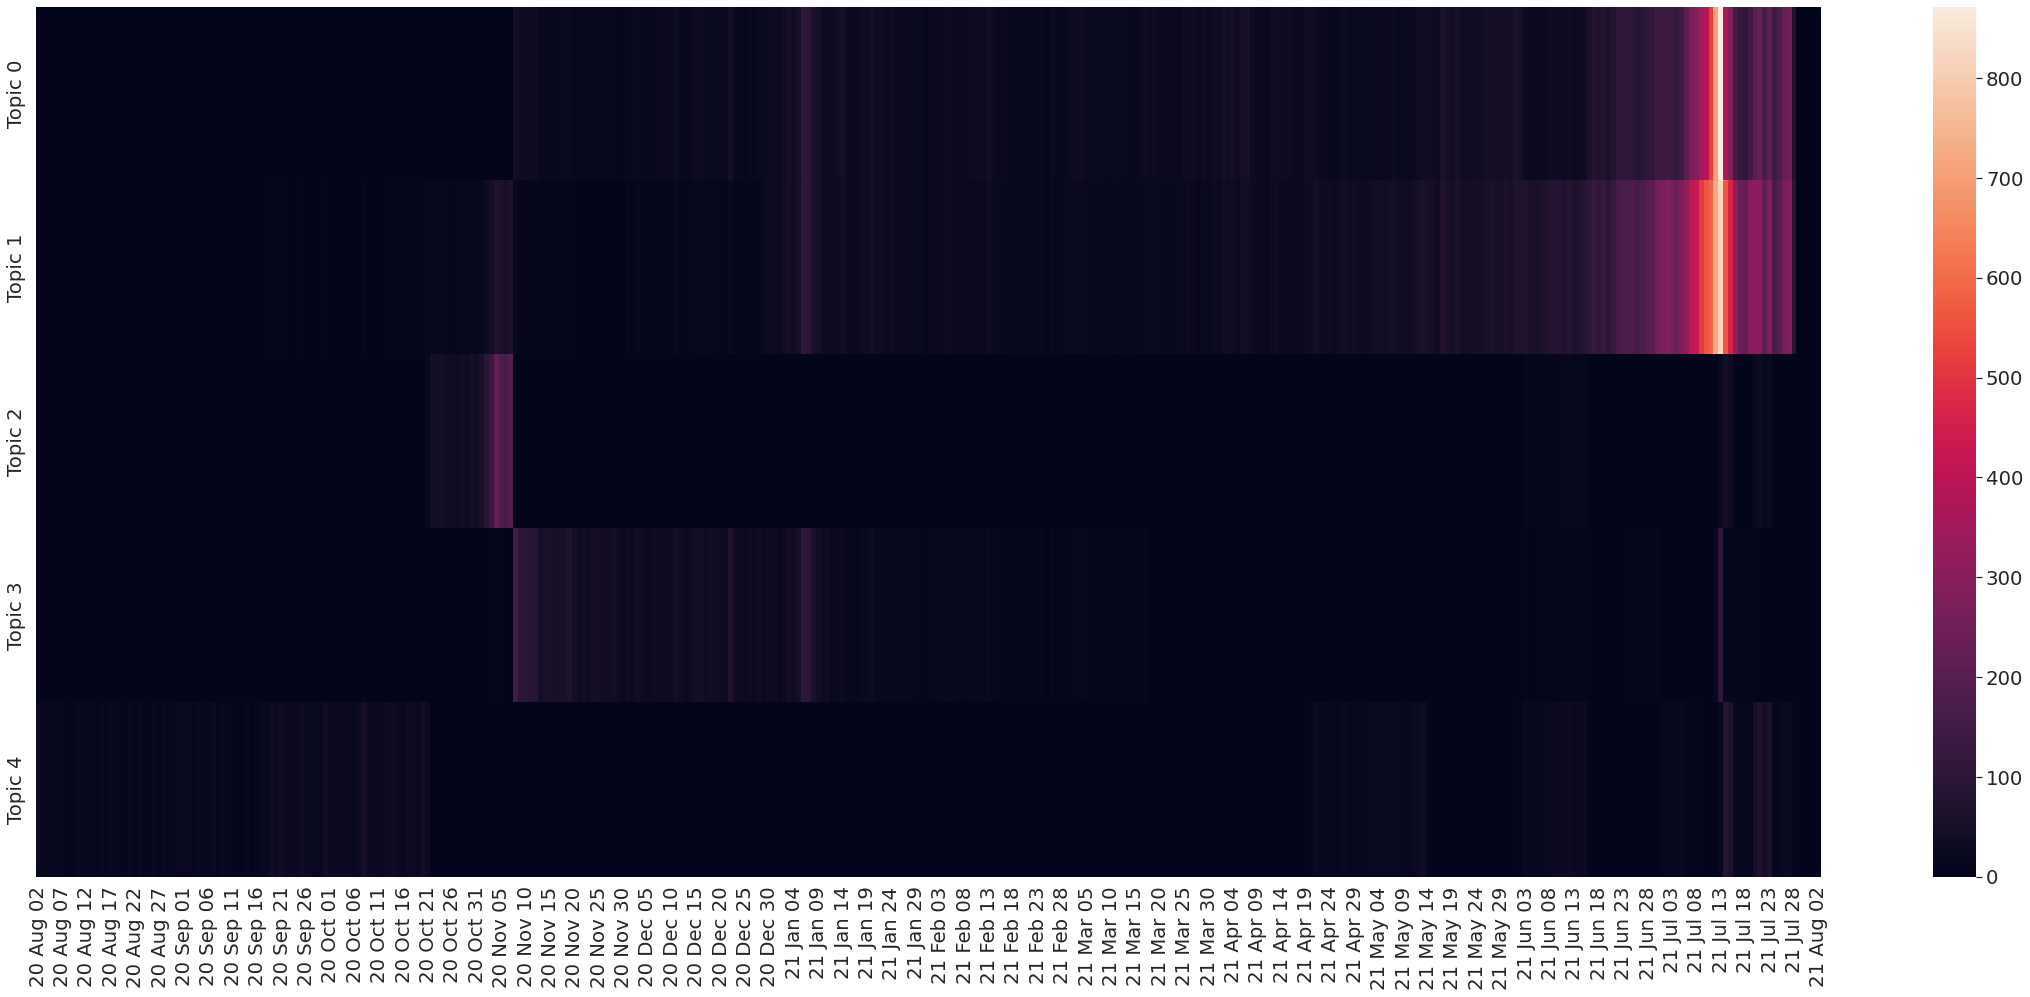

In [ ]:
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df,cmap='rocket') # viridis, inferno, plasma
plt.savefig(f'NCPD/NCPD for topic election/heatmap_{task_name}.pdf')

In [ ]:
# timestart = dt(2020, 5, 18)
# timeend = dt(2020, 6, 11)

# tweets_of_interest = comm_0_df.loc[timestart:timeend]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


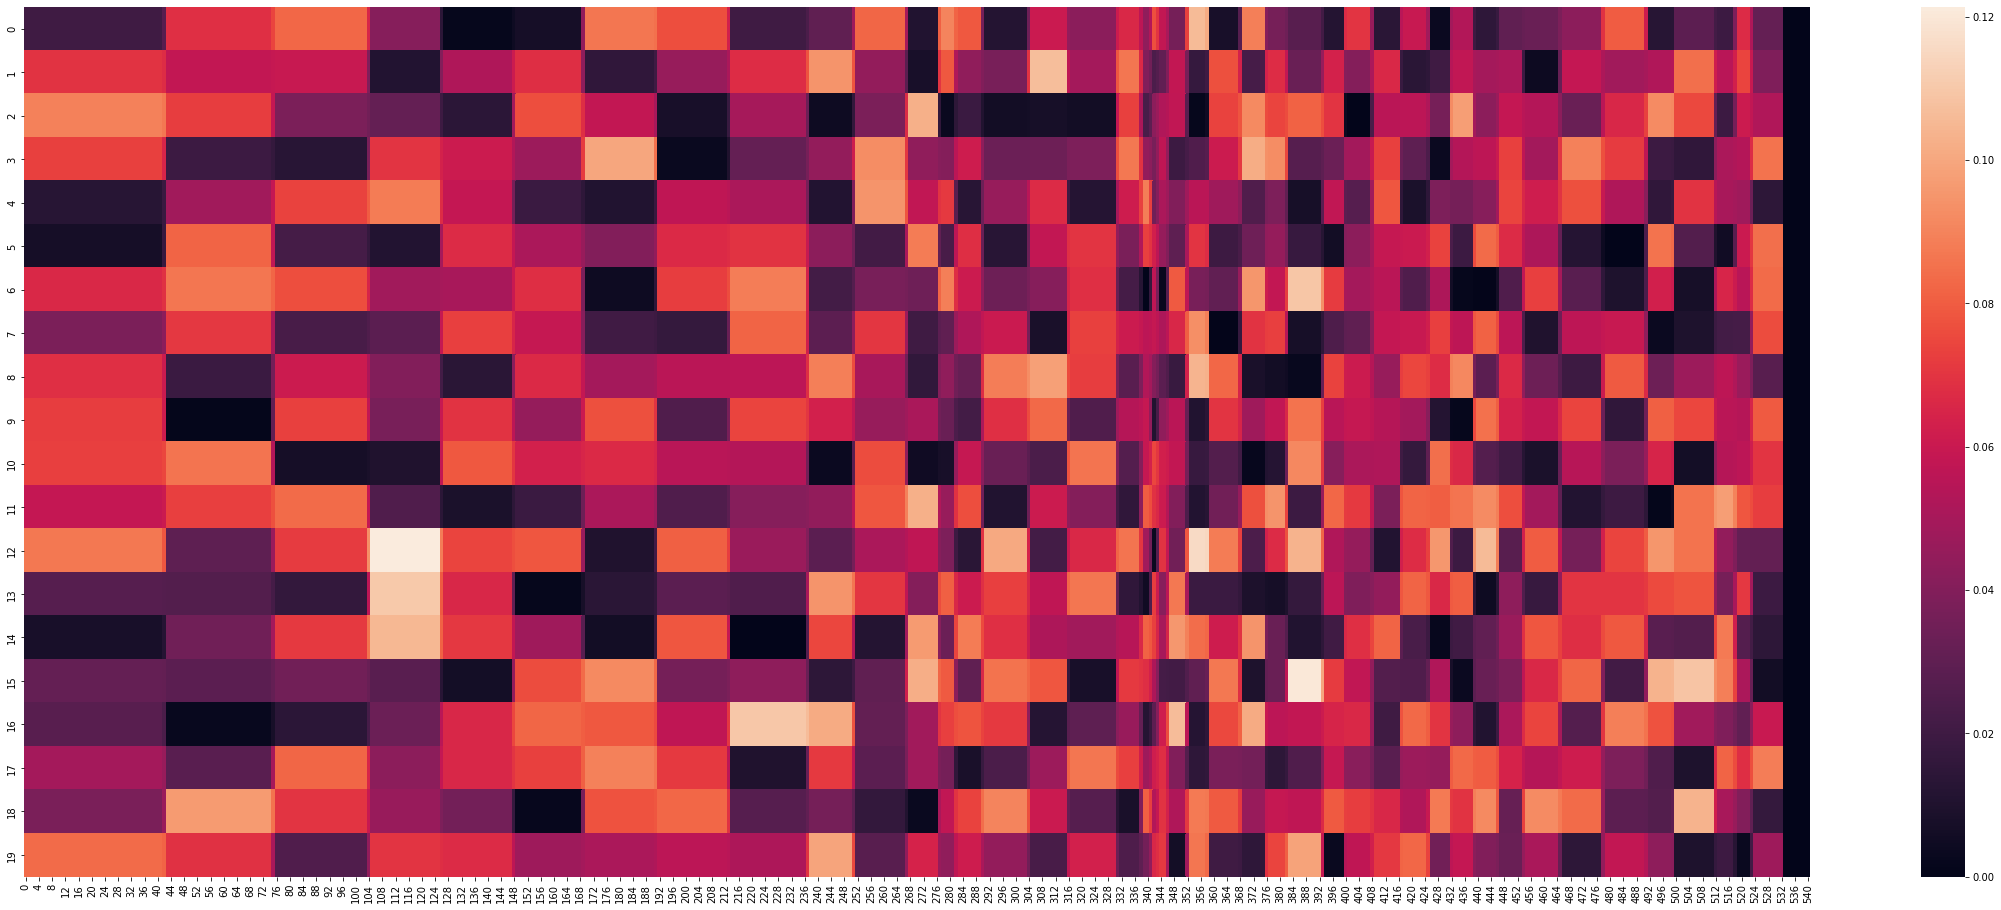

In [ ]:
time_topic_array = df.to_numpy()
# time_topic_array.shape
# np.sum(time_topic_array, axis = 0).shape
normalized_time_topic_array = time_topic_array / np.reshape(time_topic_array.sum(axis = 0), (1, 541))
normalized_time_topic_array[np.isnan(normalized_time_topic_array)] = 0

fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(normalized_time_topic_array,cmap='rocket') # viridis, inferno, plasma

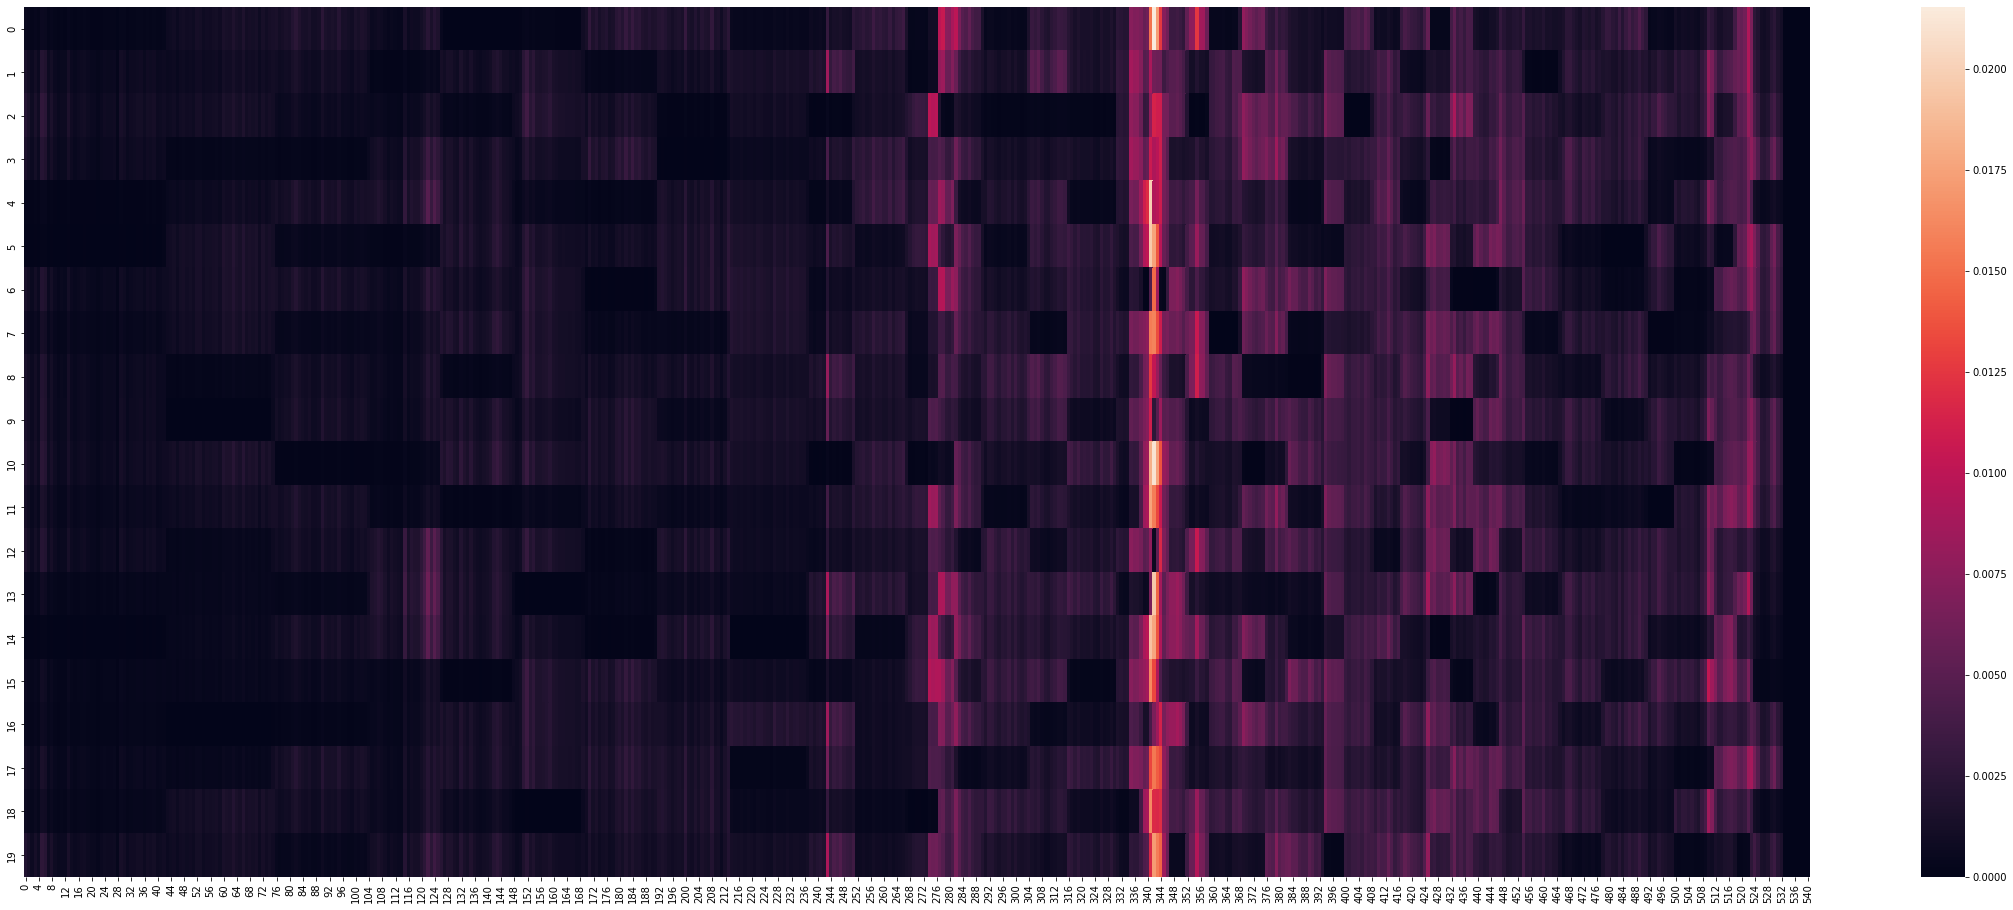

In [ ]:
time_topic_array = df.to_numpy()
# time_topic_array.shape
# np.sum(time_topic_array, axis = 0).shape
normalized_time_topic_array = time_topic_array / np.reshape(time_topic_array.sum(axis = 1), (20, 1))
normalized_time_topic_array[np.isnan(normalized_time_topic_array)] = 0

fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(normalized_time_topic_array,cmap='rocket') # viridis, inferno, plasma

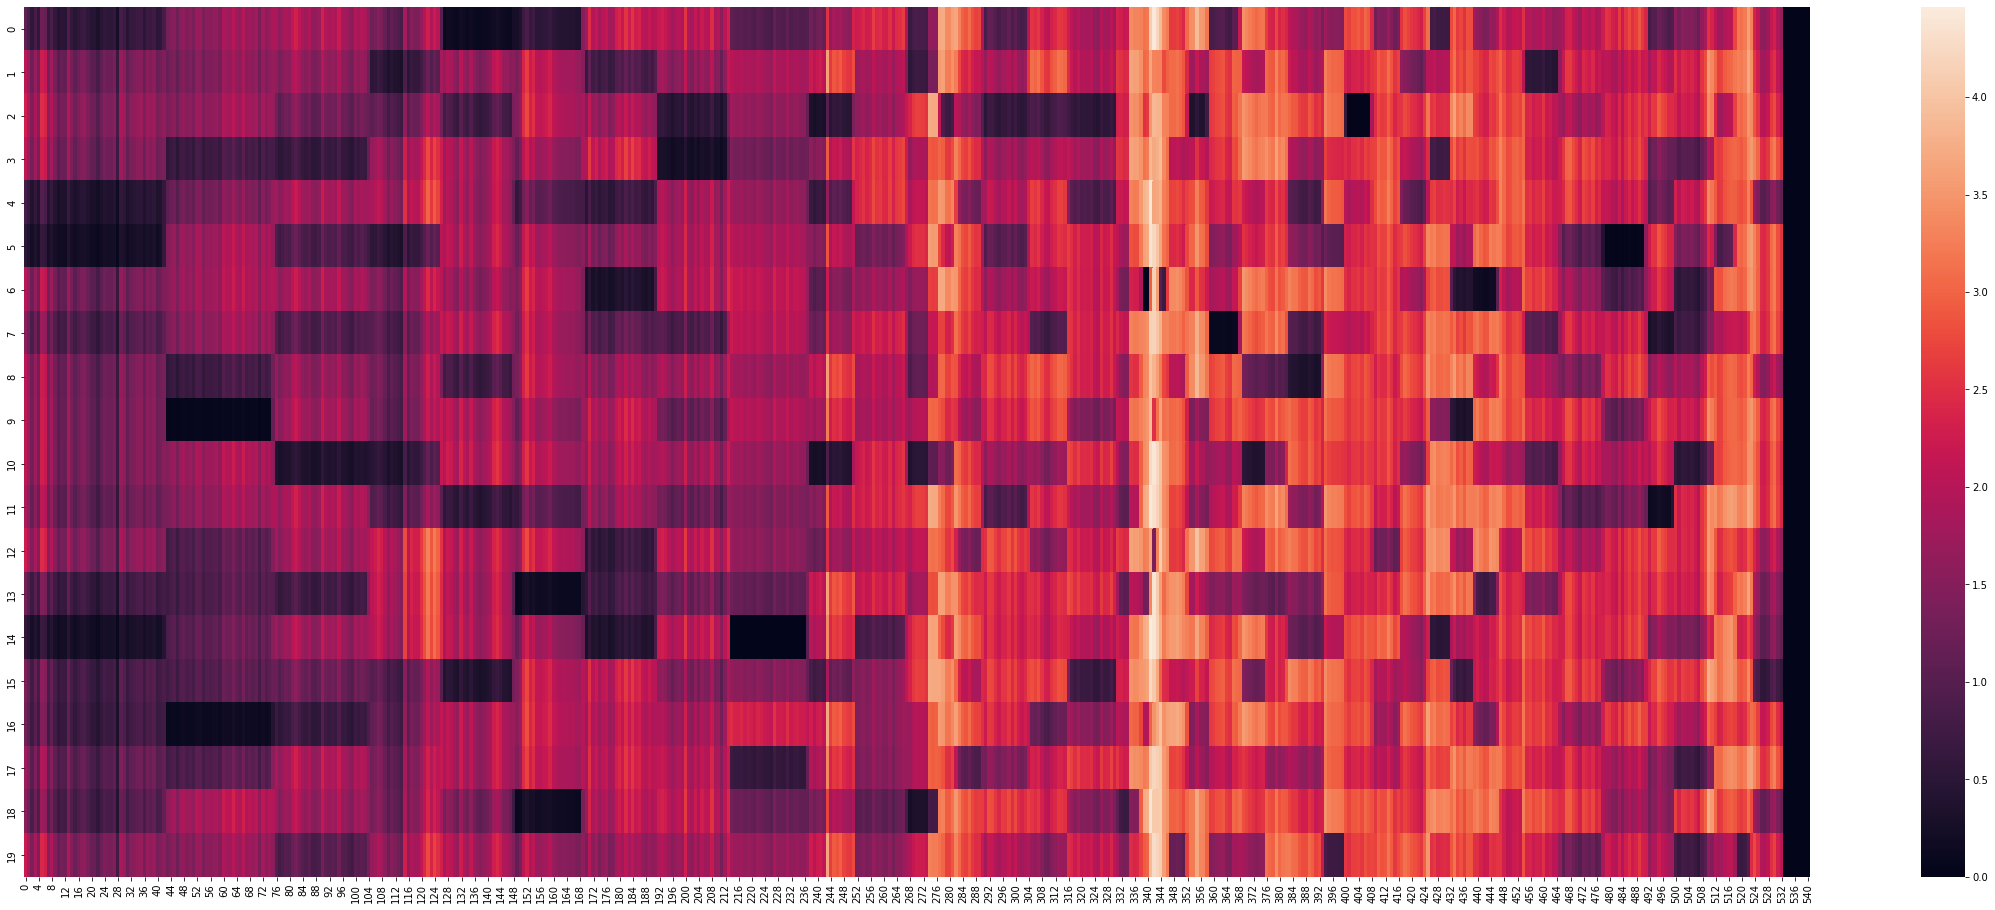

In [ ]:
time_topic_array = df.to_numpy()
normalized_time_topic_array = time_topic_array / np.reshape(time_topic_array.sum(axis = 1), (20, 1))
normalized_time_topic_array[np.isnan(normalized_time_topic_array)] = 0

fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(np.log(time_topic_array + 1),cmap='rocket') # viridis, inferno, plasma
plt.savefig(f'NCPD/NCPD Data/log_heatmap_{task_name}')

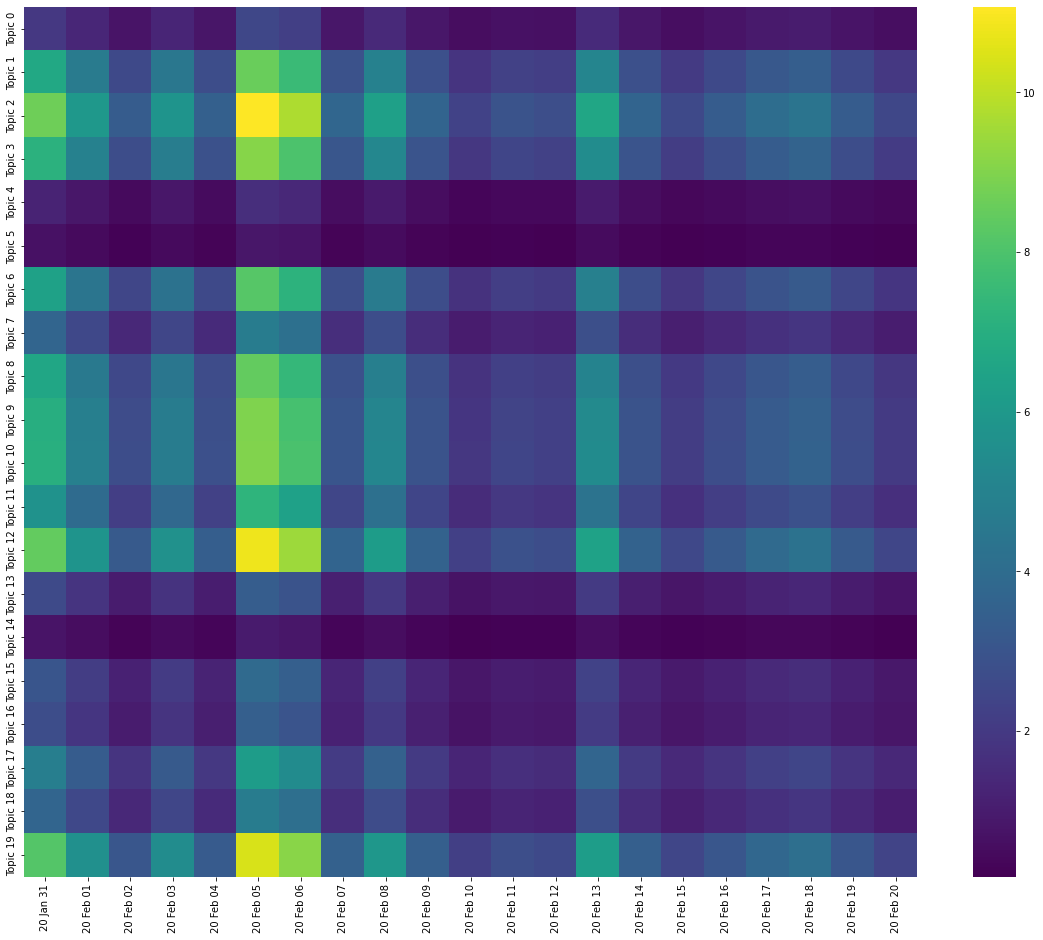

In [ ]:
Cols_Mar = Cols[:21]
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(df[Cols_Mar],cmap='viridis') # viridis, inferno, plasma
plt.savefig(outfilename('old_heatmap_March.png'))

KeyError: ignored

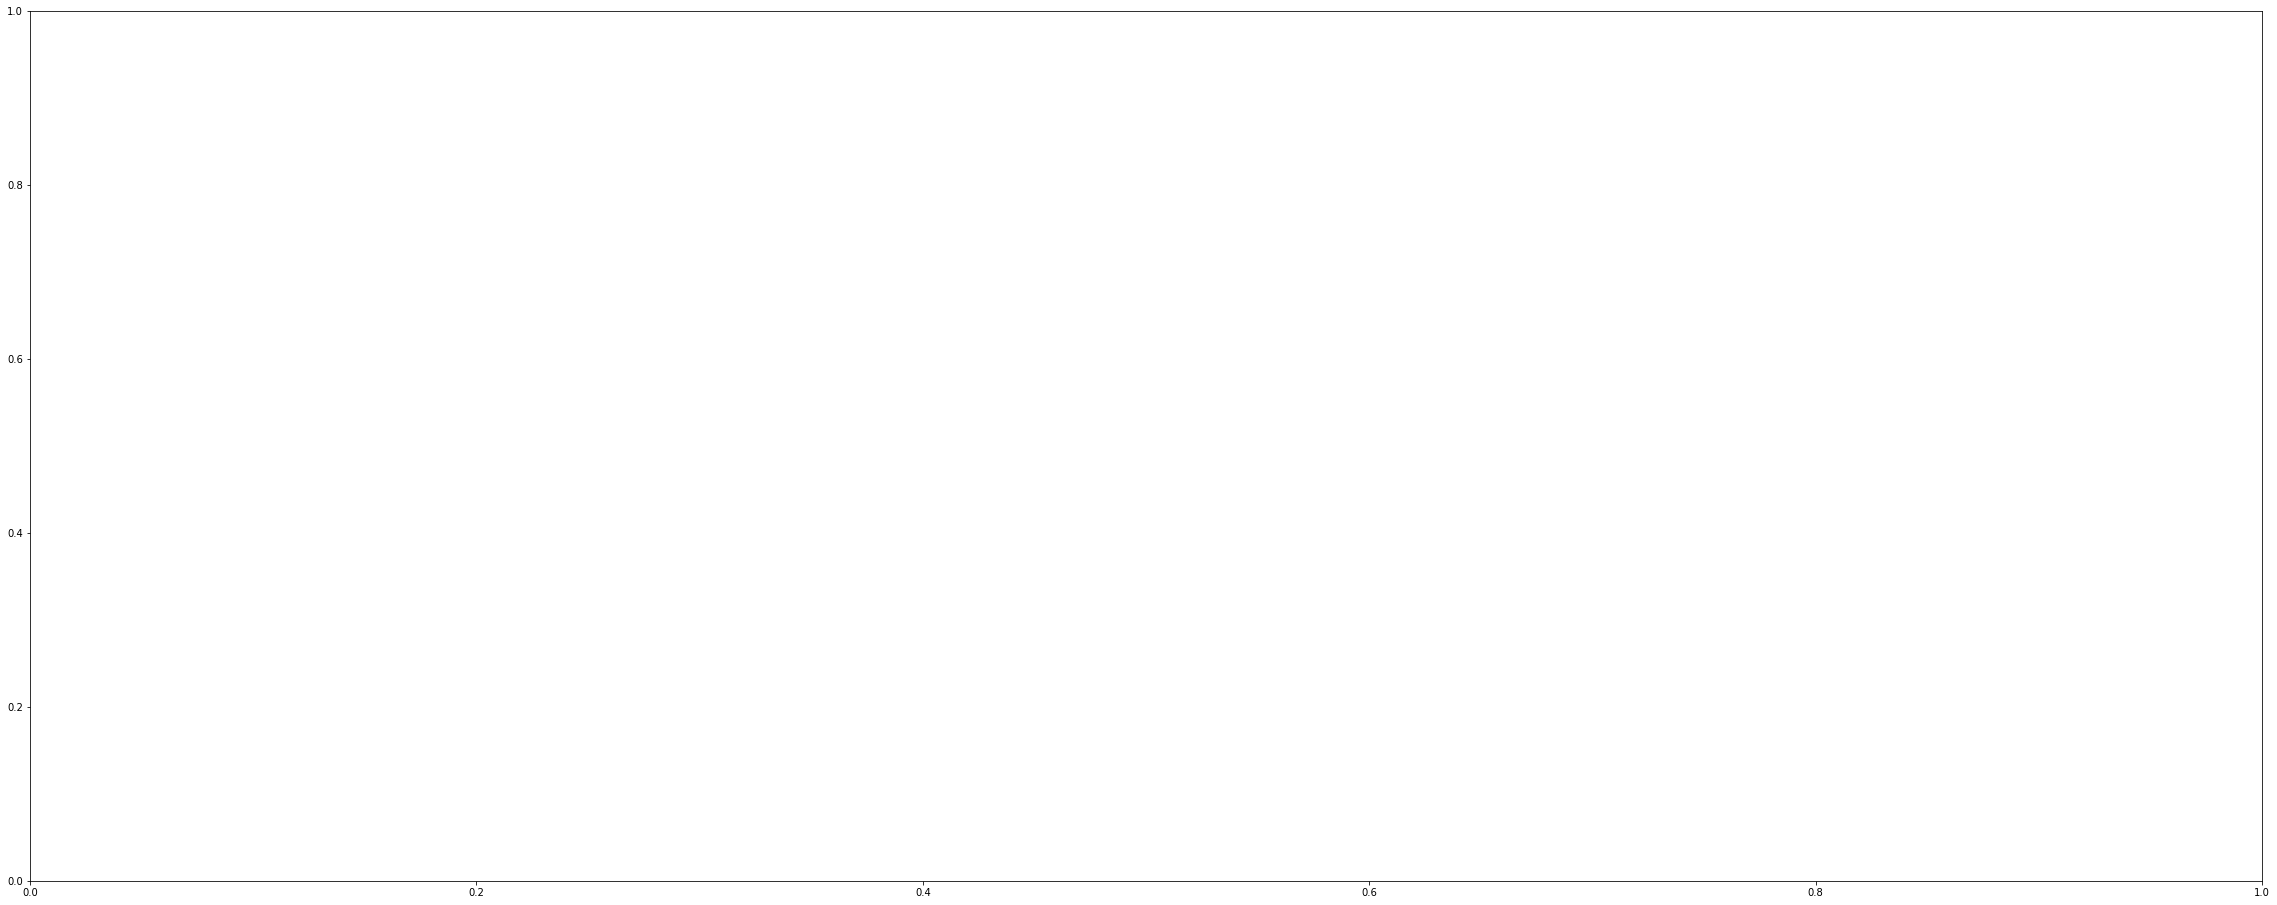

In [ ]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df[Cols[21:-6]],cmap='hot',xticklabels=False,yticklabels=False) # viridis, inferno, plasma
ax.set(title="NCPD Topics Heatmap",xlabel="Date Range: April 2020~June 2021",
      ylabel="Topics 1~20")
sns.set(font_scale=5)

plt.savefig(outfilename('test2.png'))

KeyError: ignored

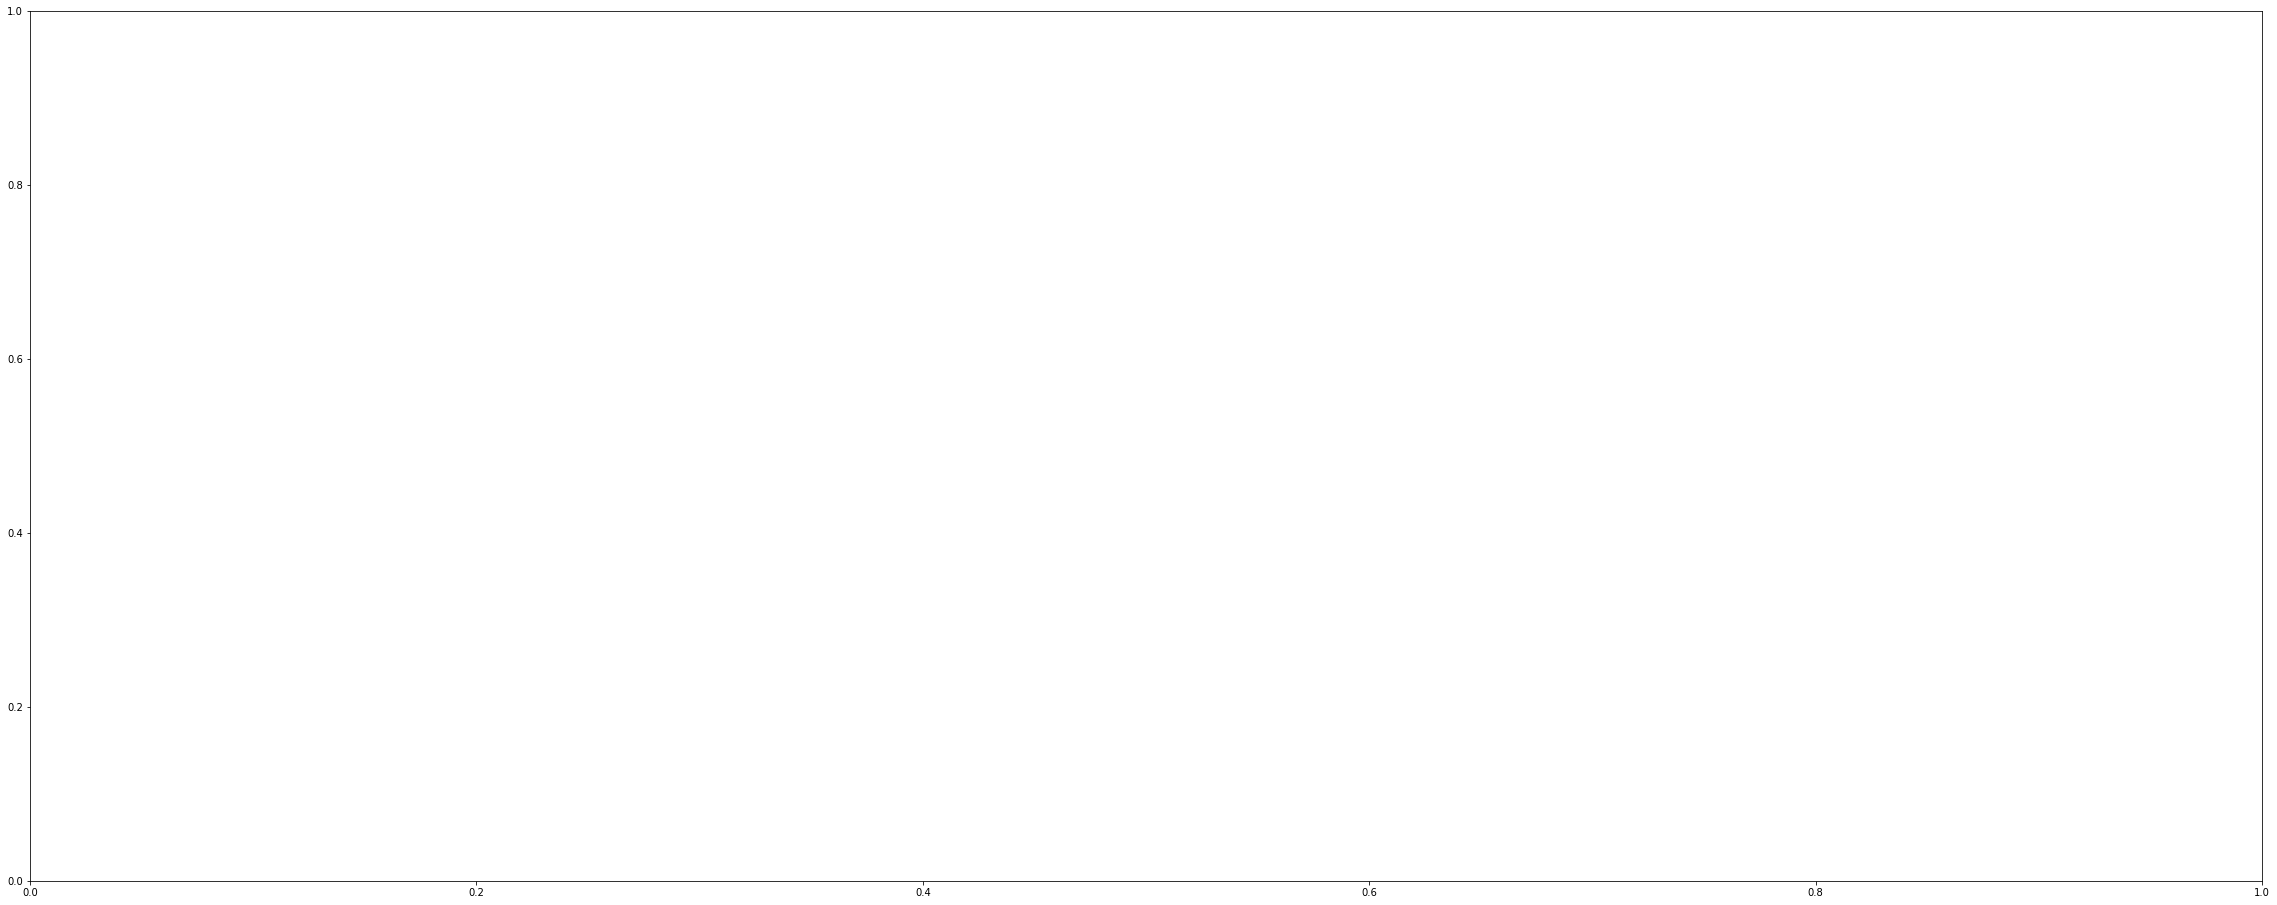

In [ ]:
fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df[Cols[21:-6]].drop(index=['Topic 4','Topic 5','Topic 11']),cmap='inferno') # viridis, inferno, plasma
plt.savefig('test.png')

In [ ]:
df2 = DataFrame(data=np.array(normalized_distr).transpose(),index=Index,columns=[str(i) for i in range(nSlices)])
print(df2)

fig, ax = plt.subplots(figsize=(40,16))
ax = sns.heatmap(df2,cmap='viridis') # viridis, inferno, plasma
plt.savefig(outfilename('slice_heatmap.png'))

ValueError: ignored

# Test

In [ ]:
for tweet in data:
  if 'orange' in tweet['text'] and (str(tweet['time'])=='2020-06-12 00:00:00'):
    print(tweet['time'],tweet['text'],'\n------------------')

2020-06-12 00:00:00 Let’s Go! I’m so hyped finally 

orange county covid death rate - 185 deaths out of 3.1 Million people.

time to open this bitch up! 
------------------
2020-06-12 00:00:00 orange county is lifting its face mask requirements and I work in a restaurant

ok 
------------------
2020-06-12 00:00:00 if i walk into a place without the must-have mask protocol....i will pull a karen bc “they just lost a customer” lol man fuck orange county :( 
------------------
